In [1]:
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_audio_path = '/content/drive/MyDrive/train/audio'


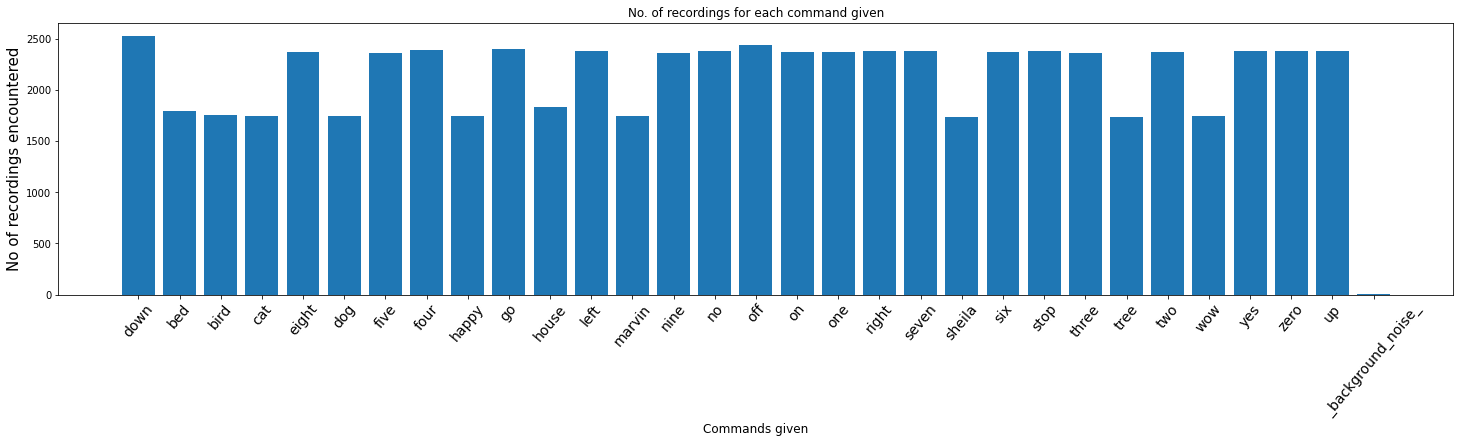

In [4]:
labels=os.listdir(train_audio_path)

#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(25,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands given', fontsize=12)
plt.ylabel('No of recordings encountered', fontsize=15)
plt.xticks(index, labels, fontsize=14, rotation=50)
plt.title('No. of recordings for each command given')
plt.show()

labels=["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "zero"]

In [5]:
train_audio_path = '/content/drive/MyDrive/train/audio'
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

one
two
three
four
five
six
seven
eight
nine
zero


In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [7]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

In [8]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [9]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),test_size = 0.25,shuffle=True)

In [10]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,15, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.1)(conv)

#Second Conv1D layer
conv = Conv1D(16, 13, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.1)(conv)

#Third Conv1D layer
conv = Conv1D(32, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.1)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.1)(conv)




#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.2)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.2)(conv)



outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7986, 8)           128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2650, 16)          1680      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 883, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 883, 16)           0     

In [11]:
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [12]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.00001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [13]:
history=model.fit(x_tr, y_tr ,epochs=15, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/15
507/507 [==============================] - 145s 284ms/step - loss: 2.3022 - accuracy: 0.1025 - val_loss: 2.2957 - val_accuracy: 0.1565
Epoch 2/15
507/507 [==============================] - 144s 284ms/step - loss: 2.2918 - accuracy: 0.1465 - val_loss: 2.2761 - val_accuracy: 0.1706
Epoch 3/15
507/507 [==============================] - 142s 279ms/step - loss: 2.2719 - accuracy: 0.1588 - val_loss: 2.2365 - val_accuracy: 0.1772
Epoch 4/15
507/507 [==============================] - 141s 279ms/step - loss: 2.2223 - accuracy: 0.1802 - val_loss: 2.0991 - val_accuracy: 0.2202
Epoch 5/15
507/507 [==============================] - 141s 277ms/step - loss: 2.1101 - accuracy: 0.2239 - val_loss: 2.4328 - val_accuracy: 0.1291
Epoch 6/15
507/507 [==============================] - 140s 276ms/step - loss: 1.9922 - accuracy: 0.2607 - val_loss: 2.5426 - val_accuracy: 0.1380
Epoch 7/15
507/507 [==============================] - 141s 279ms/step - loss: 1.8283 - accuracy: 0.3377 - val_loss: 1.6238 -

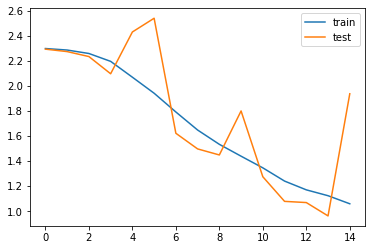

In [14]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [15]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [16]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)
print("Text:",predict(samples))

Audio: seven
Text: six
